In [2]:
import os
import argparse
import numpy as np
import pandas as pd
from scipy.stats import fisher_exact, chi2_contingency
from scipy.stats.contingency import odds_ratio
from scipy import stats
from functools import reduce

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans

import sys
sys.path.append("../src")
import utils.parsing as utpa
import utils.plotting as utpl

def get_scaled_bmi(df, categorical_cols, numerical_cols, scaled_numerical_cols):
    # define encoders
    en = LabelEncoder()
    scaler = StandardScaler()
    # select the categorical and numerical columns
    # transform the categorical columns to integer values
    for cat_col in categorical_cols:
        df[cat_col] = en.fit_transform(df[cat_col])
    # scale the numerical columns
    df[numerical_cols] = scaler.fit_transform(df.loc[:, numerical_cols])
    # scale bmi separately
    df["bmi_scaled"] = scaler.fit_transform(df.loc[:, ["bmi"]])
    # Create the target variable (bmi_residuals) using linear regression
    X = df.loc[:, categorical_cols + numerical_cols + scaled_numerical_cols]
    y = df.loc[:, 'bmi_scaled']
    model = LinearRegression()
    model.fit(X, y)
    # save the residuals for bmi
    df['bmi_residuals'] = y - model.predict(X)
    return df

def create_bmi_res_prs_decile_data(phenotype_df, all_combo_samples):
    categorical_cols = ["genetic_sex"]
    numerical_cols = ["age"] + [f"genetic_pca{i}" for i in range(1, 40)]
    scaled_numerical_cols = []#["bmi_prs"]

    phenotype_df = get_scaled_bmi(phenotype_df, categorical_cols, numerical_cols, scaled_numerical_cols)
    phenotype_df["bmi_res_decile"] = pd.qcut(phenotype_df.bmi_residuals, q=10)
    phenotype_df["bmi_res_decile_num"] = pd.qcut(phenotype_df.bmi_residuals, q=10, labels=False)
    phenotype_df["bmi_prs_decile"] = pd.qcut(phenotype_df.bmi_prs, q=10)
    phenotype_df["bmi_prs_decile_num"] = pd.qcut(phenotype_df.bmi_prs, q=10, labels=False)
    phenotype_combo_samples_df = phenotype_df.loc[phenotype_df.sample_names.astype(str).isin(list(map(str, all_combo_samples)))]
    phenotype_other_samples_df = phenotype_df.loc[~phenotype_df.sample_names.astype(str).isin(list(map(str, all_combo_samples)))]

    phenotype_other_samples_df["description"] = "Non Combo"
    phenotype_combo_samples_df["description"] = "Combo"
    phenotype_samples_df = pd.concat((phenotype_combo_samples_df, phenotype_other_samples_df))
    return phenotype_samples_df

In [3]:
cohort_file = "/data6/deepro/ukb_bmi/0_data_preparation_and_download/phenotype/data/bmi_processed/british/train_cohort_bmi.csv.gz"
combo_files = [
    "/data6/deepro/ukb_bmi/3_characterization/data/combo_info/british/discovery_combo2.csv",
    "/data6/deepro/ukb_bmi/3_characterization/data/combo_info/british/discovery_combo3.csv"
]


In [4]:
cohort_df = pd.read_csv(
    cohort_file, 
    usecols=["sample_names", "genetic_sex", "age"] + [f"genetic_pca{i}" for i in range(1, 40)] + ["bmi_prs", "bmi"])
cohort_df["sample_names"] = cohort_df.sample_names.astype(str)
combo_genes, combo_samples = utpa.get_combo_info_from_files(combo_files)

phenotype_samples_df = create_bmi_res_prs_decile_data(cohort_df, combo_samples)

In [5]:
icd_features_file = "/data6/deepro/ukb_bmi/3_characterization/data/enrichment/british/discovery/icd_features.csv.gz"
cohort_file = "/data6/deepro/ukb_bmi/3_characterization/data/enrichment/british/discovery/cohort_pheno.csv.gz"

In [6]:
def divide_into_nocomorbidity(features_df):
    no_comorbidity_df = features_df.loc[features_df.sum(axis=1)==0]
    comorbidity_df = features_df.loc[features_df.sum(axis=1)>0]
    return comorbidity_df, no_comorbidity_df

def cluster_by_comorbidity(train_features_df, test_features_df):
    train_comorbidity_df, train_no_comorbidity_df = divide_into_nocomorbidity(train_features_df)
    test_comorbidity_df, test_no_comorbidity_df = divide_into_nocomorbidity(test_features_df)
    train_no_comorbidity_df["labels"] = 0
    test_no_comorbidity_df["labels"] = 0
    no_comorbidity_df = pd.concat((train_no_comorbidity_df, test_no_comorbidity_df))

    X_train, X_test = train_comorbidity_df.values, test_comorbidity_df.values
    kmeans = KMeans(n_clusters=2, random_state=42, n_init="auto")
    y_train = kmeans.fit_predict(X_train)
    y_test = kmeans.fit_predict(X_test)
    
    train_comorbidity_df["labels"] = y_train
    test_comorbidity_df["labels"] = y_test
    comorbidity_df = pd.concat((train_comorbidity_df, test_comorbidity_df))
    comorbidity_df["labels"] = comorbidity_df.labels.replace(0, 2)
    icd_df = pd.concat((comorbidity_df, no_comorbidity_df))
    return icd_df

In [7]:
icd_features_df = pd.read_csv(icd_features_file, index_col=0)
icd_features_df.index = icd_features_df.index.astype(str)


cohort_df = pd.read_csv(cohort_file, usecols=["sample_names", "bmi_prs", "bmi", "bmi_residuals", "carrier"], dtype={"sample_names": str})

combo_samples = set(cohort_df.loc[cohort_df.carrier==True, "sample_names"].values)
noncombo_samples = set(cohort_df.loc[cohort_df.carrier==False, "sample_names"].values)
combo_features_df = icd_features_df.loc[icd_features_df.index.isin(combo_samples)]
noncombo_features_df = icd_features_df.loc[icd_features_df.index.isin(noncombo_samples)]

icd_df = cluster_by_comorbidity(noncombo_features_df, combo_features_df)


In [8]:
phenotype_samples_df = phenotype_samples_df.loc[:, ["sample_names", "bmi", "bmi_res_decile_num", "bmi_prs_decile_num", "description"]]

In [9]:
bmi_res_comorbidity_df = phenotype_samples_df.merge(icd_df.loc[:, "labels"].to_frame(), left_on="sample_names", right_index=True)

In [10]:
bmi_res_comorbidity_df

,sample_names,bmi,bmi_res_decile_num,bmi_prs_decile_num,description,labels
110,1005637,26.28970,4,4,Combo,1
118,1006065,49.98170,9,8,Combo,2
154,1007953,30.68310,7,6,Combo,0
162,1008528,27.05520,6,9,Combo,1
192,1010258,31.27685,8,3,Combo,1
...,...,...,...,...,...,...
427632,6024770,24.47390,2,0,Non Combo,0
427633,6024818,27.60950,5,4,Non Combo,1
427634,6024948,47.22080,9,7,Non Combo,2
427637,6025181,26.49910,4,5,Non Combo,0


In [11]:
def get_comorbidity_percent_by_res_cat(df):
    df1 = df.groupby("comorbid_categories")["bmi_res_categories"].value_counts(normalize=True)
    df1 = df1.mul(100)
    df1 = df1.rename('percent').reset_index()
    mean_bmi_dict = df.groupby("bmi_res_categories")["bmi"].mean().to_dict()
    return df1, mean_bmi_dict

def get_bmi_res_decile_data_comorbidity_percent(phenotype_samples_df):
    phenotype_samples_df["bmi_res_categories"] = phenotype_samples_df.bmi_res_decile_num.map({
        0: "underweight", 
        1:"normal", 2:"normal", 
        3:"overweight", 4:"overweight", 5:"overweight", 6:"overweight", 7:"overweight",
        8:"obese", 9:"severe obesity"
        })
    phenotype_samples_df["comorbid_categories"] = phenotype_samples_df.labels.map({
        0: "lowest", 
        1:"middle", 2:"highest"
        })
    phenotype_combo_samples_df = phenotype_samples_df.loc[phenotype_samples_df.description=="Combo"]
    phenotype_other_samples_df = phenotype_samples_df.loc[phenotype_samples_df.description=="Non Combo"]
    phenotype_combo_samples_plot_df, cbmi_dict = get_comorbidity_percent_by_res_cat(phenotype_combo_samples_df)
    phenotype_other_samples_plot_df, ncbmi_dict = get_comorbidity_percent_by_res_cat(phenotype_other_samples_df)
    return phenotype_combo_samples_plot_df, cbmi_dict, phenotype_other_samples_plot_df, ncbmi_dict

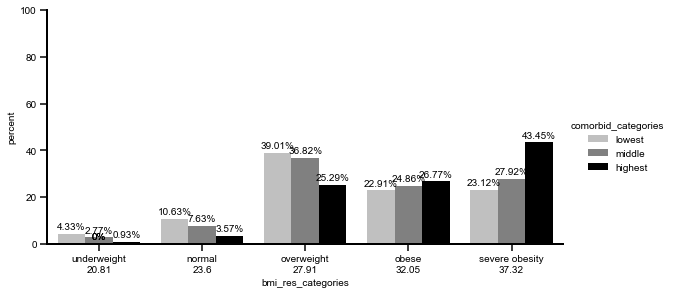

In [12]:
phenotype_combo_samples_plot_df, cbmi_dict, phenotype_other_samples_plot_df, ncbmi_dict = get_bmi_res_decile_data_comorbidity_percent(bmi_res_comorbidity_df)
fig = utpl.get_prs_bmi_res_decile_plot(phenotype_combo_samples_plot_df, cbmi_dict, hue="comorbid_categories")

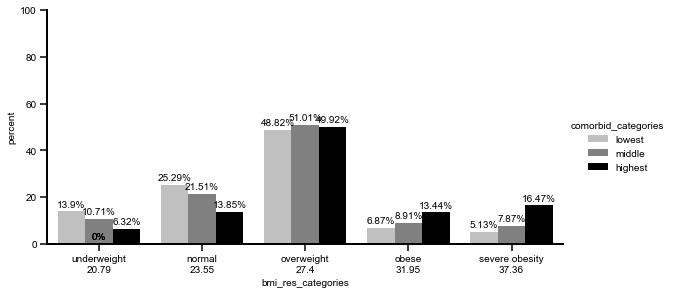

In [13]:
fig = utpl.get_prs_bmi_res_decile_plot(phenotype_other_samples_plot_df, ncbmi_dict, hue="comorbid_categories")

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

In [15]:
def create_decile_comorbid_plot_helper(df, deciles):
    plot_df = df.loc[df.bmi_res_decile_num.isin(deciles)]
    plot_df = plot_df.groupby(["description"])["labels"].value_counts(normalize=True) 
    plot_df = plot_df.mul(100)
    plot_df = plot_df.rename('percent').reset_index()
    return plot_df

def create_decile_comorbid_plot(df, decile_of_interest):
    other_deciles = [i for i in range(10) if i<decile_of_interest]
    plot_df1 = create_decile_comorbid_plot_helper(df, [decile_of_interest])
    plot_df2 = create_decile_comorbid_plot_helper(df, other_deciles)
    fig, ax = plt.subplots(1,2, figsize=(8,6), sharey=True)
    sns.barplot(plot_df1, x="labels", y="percent", hue="description", order=[0,1,2], hue_order=["Non Combo", "Combo"], ax=ax[0])
    ax[0].set_title(f"Decile {decile_of_interest+1}")
    sns.barplot(plot_df2, x="labels", y="percent", hue="description", order=[0,1,2], hue_order=["Non Combo", "Combo"], ax=ax[1])
    ax[1].set_title(f"Other deciles")
    return fig

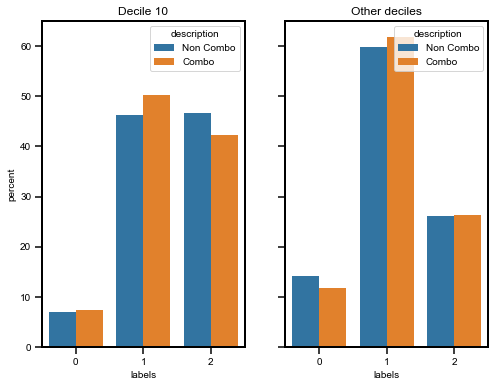

In [18]:
f = create_decile_comorbid_plot(bmi_res_comorbidity_df, 9)

In [47]:
def create_decile_comorbid_table_helper(df, deciles):
    table_df = df.loc[df.bmi_res_decile_num.isin(deciles)]
    table_df = table_df.groupby(["description"])["sample_names"].count()
    table_df.name = "_".join(list(map(str, deciles)))
    return table_df.to_frame()

def create_table(df, label, decile_of_interest):
    label_df = df.loc[df.labels==label]
    other_deciles = [i for i in range(10) if i!=decile_of_interest]
    decile_of_interest_table = create_decile_comorbid_table_helper(label_df, [decile_of_interest])
    other_deciles_table = create_decile_comorbid_table_helper(label_df, other_deciles)
    table_df = pd.concat((decile_of_interest_table, other_deciles_table), axis=1)
    return table_df


for label in bmi_res_comorbidity_df.labels.unique():
    print(label)
    table_df = create_table(bmi_res_comorbidity_df, label, 9)
    print(table_df)


1
                 9      8
description              
Combo         1504   1339
Non Combo    17180  19466
2
                 9      8
description              
Combo         1266    780
Non Combo    17337  14156
0
                9     8
description            
Combo         224   222
Non Combo    2577  3451


In [34]:
bmi_res_comorbidity_sel_df = bmi_res_comorbidity_df.loc[bmi_res_comorbidity_df.bmi_res_decile_num.isin([9,0])]
bmi_res_comorbidity_sel_df["bmi_res_binary_decile"] = bmi_res_comorbidity_sel_df.bmi_res_decile_num.apply(lambda x: "extreme" if x==9 else "others")
bmi_res_comorbidity_sel_df["comorbidity_binary_decile"] = bmi_res_comorbidity_sel_df.labels.apply(lambda x: "extreme" if x==2 else "others")

In [28]:
decile_of_interest = 9
other_deciles = [ i for i in range(10) if i<decile_of_interest] 
bmi_res_comorbidity_sel_df = bmi_res_comorbidity_df.loc[bmi_res_comorbidity_df.bmi_res_decile_num.isin(other_deciles + [decile_of_interest])] #7,6,5,4,3,2,1,0
bmi_res_comorbidity_sel_df["bmi_res_binary_decile"] = bmi_res_comorbidity_sel_df.bmi_res_decile_num.apply(lambda x: "extreme" if x==decile_of_interest else "others")
bmi_res_comorbidity_sel_df["comorbidity_binary_decile"] = bmi_res_comorbidity_sel_df.labels.apply(lambda x: "extreme" if x==2 else "others")

def create_decile_comorbid_table_helper(df):
    table_df = df.groupby(["description"])["comorbidity_binary_decile"].value_counts()
    return table_df.reset_index().pivot_table(index="description", columns="comorbidity_binary_decile", values="count")

def create_table(df, bmi_res_binary_decile):
    bmi_res_decile_df = df.loc[df.bmi_res_binary_decile==bmi_res_binary_decile]
    table_df = create_decile_comorbid_table_helper(bmi_res_decile_df)
    return table_df

for bmi_res_binary_decile in bmi_res_comorbidity_sel_df.bmi_res_binary_decile.unique():
    print(bmi_res_binary_decile)
    table_df = create_table(bmi_res_comorbidity_sel_df, bmi_res_binary_decile)
    print(table_df)
    res = fisher_exact(table_df)
    print(res.statistic, res.pvalue)

others
comorbidity_binary_decile  extreme    others
description                                 
Combo                       1648.0    4627.0
Non Combo                  87956.0  248934.0
1.0080369575518058 0.7828877742560478
extreme
comorbidity_binary_decile  extreme   others
description                                
Combo                       1266.0   1728.0
Non Combo                  17337.0  19757.0
0.8349049159472676 2.517814889240206e-06


In [48]:
bmi_res_comorbidity_df.loc[bmi_res_comorbidity_df.bmi_res_decile_num==9].groupby(["description"])["labels"].value_counts(normalize=True)

description  labels
Combo        1         0.502338
             2         0.422846
             0         0.074816
Non Combo    2         0.467380
             1         0.463148
             0         0.069472
Name: proportion, dtype: float64

In [45]:
bmi_res_comorbidity_df.groupby(["description"])["labels"].value_counts(normalize=True)

description  labels
Combo        1         0.581077
             2         0.314381
             0         0.104542
Non Combo    1         0.584044
             2         0.281544
             0         0.134412
Name: proportion, dtype: float64